# Synthetic Geomagnetic Storms

## Basic description of toy forward model

This notebook explores what network architectures work for predicting synthetic geomagnetic storms from impulses, which represent the integrated Xhf peaks described by Tobiska 2013. These impulses contain information about the propagation speed of mass ejections from the solar corona and thereby also about the time lag between ejection and storm as well as the ultimate magnitude of the storm.

Here I generate random impulses, ranging initially on a linear scale (one order of magnitude of variation). This should actually be larger variation to resemble the true Xhf data, but I'll add this complication later. The input to the neural network will then be a time history of impulses, say from the past 5 days.

The forward model will then be one that generates time lags associated with the impulses (with noise added) as well as Dst deflection magnitudes that roughly also scale with the impulse magnitude. My current implementation represents the lags uncertaintly, meaning that each lag has a mean related deterministically to a velocity computed directly from the impulse magnitude, but the actual lag is sampled from a normal distribution with a prescribed, constant variance. However, it might make more sense to represent the velocity with uncertainty, taking care to make sure that the velocity can never be considered zero or negative. The magnitude also has a mean deterministically computed from the impulse value and also ultimately drawn from a normal distribution with a prescribed variance.

These two parameters will then describe the storm, with the main phase being an essentially instantaneous descent in Dst to the maximum deflection and then an exponential decay back to the background value of 0. The timescale of exponential decay will be the same in all storms (for now).  

### Filtering by location on disk

Amajor complication that will eventually need to be added is a sort of filtering based on impulse emission location. Tobiska 2013 identify particular regions on the solar disk from which solar ejections actually are geoeffective, meaning that many of the peaks in Xhf do not actually generate Dst anomalies because their association ejecta do not reach Earth's magnetosphere. 

In this toy example, this means that I need to include as part of the forward problem a set of coordinates for which a basic sort of noisy thresholding occurs, meaning that impulses further away from the center of the disk are less likely to be associated with geoeffective ejections. Only the largest ejections away from the center of the disk will generate storms, meaning that the probability should be weighted by the ejection size.

### CME database relevance

To be discussed...

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
from scipy import signal
from sklearn import preprocessing
from scipy import stats

from helper_functions import *

## Generate input and output data

### Input

The input data are designed to mimic the model of Tobiska et al. (2013), where solar x-ray fluxes correspond to flares that are often associated with geoeffective mass ejections. The relevant input series are then:

1) integrated peak magnitudes, represented as impulses,

2) flare location information, represented as coordinates on a simulated solar hemisphere

In this model, storm magnitude will decrease with distance of the impulse from the center of the solar disk.

In [2]:
ndat = 100000

# maximum velocity (impulse amplitude)
max_vel = 5

# generate input impulses
impulses = np.random.randint(0, max_vel+1, (ndat, 1))

# set most speeds randomly to zero
rnd_idx = np.random.randint(0, 30, ndat)
rnd_idx = rnd_idx < 29
impulses[rnd_idx] = 0

# for each impulse, generate location coordinates randomly (lat lon)
locations = np.concatenate((np.random.rand(), 
                           ), axis=1)

locations[rnd_idx, :] = 0

data_in = np.conatenate((impulses, locations), axis=1)

### Output

In [3]:
# initialize output with extra entries
data_out = np.zeros((ndat+1000, 1))

# arbitrary distance (modeling Earth-Sun distance)
d = 16*24
# decay constant
tau = 0.05 
t = np.arange(0,500).reshape(-1, 1)

for ii in tqdm_notebook(range(ndat)):
    if data_in[ii] != 0:
        # generate velocity
        v = data_in[ii] + 2
        # generate lag time mean
        lag_mu = d/v
        # prescribe lag time standard deviation (in hours)
        lag_std = 4
        # generate lag randomly
        lag = int(np.random.normal(loc=lag_mu, scale=lag_std, size=1))
        # generate magnitude mean
        mag_mu = 8*(v**1.8)
        # prescribe magnitude standard deviation (nT)
        mag_std = 10
        # generate magnitude randomly
        mag = int(np.random.normal(loc=mag_mu, scale=mag_std, size=1))
        # generate decay profile based on most recent, largest Est excursion
        if mag > data_out[ii+lag]:
            data_out[ii+lag:ii+lag+500] = mag*np.exp(-tau*t)
        
# keep only first ndat values
data_out = data_out[0:ndat]

Since we will use previous values of Dst as input as well, we will add the computed output to the impulse series to generate full input array.

In [4]:
data_in = np.concatenate((data_in, data_out), axis=1)

## Split

In [5]:
lahead = 24
train_percent = 0.9
test_percent = 0.1
val_percent = 0.0
batch_size = 1000

In [6]:
in_slice = slice(0, ndat-lahead)
out_slice = slice(lahead, ndat)

data_in_shift = data_in[in_slice].astype(np.float32)
data_out_shift = data_out[out_slice].astype(np.float32)

ndat_shift = data_in_shift.shape[0]

In [7]:
# get indices
train_idx = np.zeros(ndat_shift, dtype=bool)
rlim = int(train_percent*ndat_shift) - (int(train_percent*ndat_shift) % batch_size)
train_idx[0:rlim] = 1
ntrain = np.sum(train_idx)

test_idx = np.ones(ndat_shift, dtype=bool)
test_idx[train_idx] = 0
ntest = np.sum(test_idx)

# split data
data_in_train = data_in_shift[train_idx]
data_out_train = data_out_shift[train_idx]

data_in_test = data_in_shift[test_idx]
data_out_test = data_out_shift[test_idx]

# normalize and reshape
scaler_input = preprocessing.MinMaxScaler(feature_range=(0,1))
data_in_train_scaled = scaler_input.fit_transform(data_in_train)
data_in_test_scaled = scaler_input.transform(data_in_test)

scaler_output = preprocessing.MinMaxScaler(feature_range=(0,1))
data_out_train_scaled = scaler_input.fit_transform(data_out_train)
data_out_test_scaled = scaler_input.transform(data_out_test)

### Visualizes

Show some side-by-side of input and output.

Text(0.5, 1.0, 'toy model, 24 hour ahead forecast')

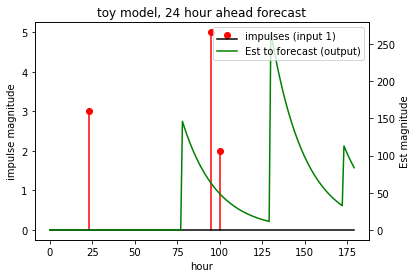

In [19]:
plot_idx = slice(120, 300)

# set impulses of zero to nan
tmp = data_in_train[plot_idx, 0].copy()
tmp[tmp == 0] = np.nan

fig = plt.figure(figsize=[6,4])
ax1 = plt.axes()
ax2 = ax1.twinx()
# impulses
l1 = ax1.stem(tmp, linefmt='r-', markerfmt='ro', basefmt='k-', label='impulses (input 1)')
# previous Dst
# l2 = ax2.plot(data_in_train[plot_idx, 1], 'k--', label='previous Dst (input)')
# Dst lahead 
l3 = ax2.plot(data_out_train[plot_idx], color='g', label='Est to forecast (output)')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
ax1.set_xlabel('hour')
ax1.set_ylabel('impulse magnitude')
ax2.set_ylabel('Est magnitude')
plt.title('toy model, 24 hour ahead forecast')

# plt.savefig('../figures/toy_model_data_example.pdf', format='pdf')

## Design network, Train, Test

Here I design the network to figure out the toy problem. This network contains two couple parts:

1) The job of the first part of the network is to effectively convert the impulse value into a broad curve of conceivable arrival impulses, as shown in the following figure. This transformation reflects the uncertainty in storm arrival, but the mean of this curve of arrival impulses should be inversely related to the impulse size, since larger impulses mean faster velocities, which in turn mean shorter lag times. Furthermore, the arrival impulse curve itself should also have uncertainty, since the ultimate Dst deviation from an impulse is uncertain. To represent this, I'll feed the 5%, 50%, and 95% percentiles, meaning that there will actually be three curves output from each impulse (ideally).
<img src='figures/impulse_conversion.jpg' width='500px'>

However, the network will have to learn this representation. This part of the network will actually receive as input a time history of impulses up to the present. Then, this history will be fed through a couple dense layers, with the last dense layer outputting four parameters for each of the input time steps: lag mean, magnitude mean, lag standard deviation, and magnitude standard deviation. These parameters are fed to an output distribution layer that transforms them into parameters of normal distributions, effectively then generating two distributions for each input time step.

What we want is the time history up until the t+kth hour, however, while the input time history is only to the tth hour. So for a batch size $b$, we then initialize a tensor of the same batch size that contains time steps tt+k-b to tt+k and with three columns, containing the 5%, 50%, and 95% confidence intervals.

We then populate this tensor by sampling

2) The second part of the network takes the impulse arrival curves from the first part as input and additionally takes previous Dst as inputs for the final forecasting of Dst at t+k.

In [9]:
from tensorflow.python.framework import ops

# custom layer class for computing arrival curves from lags
class ArrivalsLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(ArrivalsLayer, self).__init__()

    def build(self, input_shape): 
        self.n_batch = input_shape[0]
    
    # inputs have following structure: 
    # first means, with first means for velocities and second for magnitudes
    # second standard deviations
    def call(self, inputs):
        inputs = ops.convert_to_tensor(inputs)
        # number of data points in batch
        self.n_batch = inputs.shape[0]
        # indices in output time vecotr (see notes)
        self.idx_offset = np.arange(self.n_batch)
        vel_mu = inputs[:, 0] + 1e-2
        #sigs = inputs[:, 1]
        lag_sig = 10*np.ones((self.n_batch, 1)).astype(np.float32)
        # convert velocity to lag
        lag_mu = d/vel_mu
        # compute offset lags in terms of output time vector 
        lag_mu = lag_mu + self.idx_offset - lahead
        lag_mu = tf.reshape(lag_mu, [1, -1])
        lag_sig = tf.math.softplus(1e-3 + tf.reshape(lag_sig, [1, -1]))
        # compute magnitude 
        mag_mu = tf.reshape(inputs[:, 1], [1, -1])
        # evaluate distribution at mus
        arr = mag_mu/np.sqrt(2*np.pi) * 1/lag_sig * tf.exp(-1/(2*tf.pow(lag_sig, 2)) * tf.pow(self.idx_offset.reshape(-1,1) - lag_mu, 2))
        arr = tf.reshape(tf.reduce_max(arr, 1), [-1, 1])
        return arr
#         lag_dist = tfp.distributions.Normal(loc=mus_out, scale=input[:,2])
#         mag_dist = tfp.distributions.Normal(loc=input[:,1], scale=input[:,3])
#         arr = lag_dist.prob(self.idx_offset.reshape(-1,1))
        # multiply by 5, 50, 95 percentiles of magnitude
#         arr5 = tf.multiply(arr, mag_dist.quantile(0.05))
#         arr50 = tf.multiply(arr, mag_dist)
#         arr95 = tf.multiply(arr, mag_dist.quantile(0.95))
        # take maxes along columns
#         arr5_max = tf.reshape(tf.mean(arr5, 1), [-1, 1])
#         arr50_max = tf.reshape(tf.reduce_mean(arr50, 1), [-1, 1])
#         arr95_max = tf.reshape(tf.mean(arr95, 1), [-1, 1])
        # combine
#         arr_comb = tf.concat([arr5_max, arr50_max, arr95_max], 1)
#         return arr

## Build Keras model

The following code implements the sort of hand-crafted layers that convert impulses to velocities and amplitudes.

In [15]:
IN_1 = tf.keras.layers.Input(shape=(1, ), 
                             batch_size=batch_size, 
                             name='impulses')
D_1 = tf.keras.layers.Dense(2, 
                            activation='tanh', 
                            kernel_initializer=tf.keras.initializers.Constant([5, 0.05]), 
                            use_bias=False,
                            name='D_1')(IN_1)
D_2 = tf.keras.layers.Dense(2, 
                            activation='relu', 
                            kernel_initializer=tf.keras.initializers.Constant([[2, 2], 
                                                                               [20, 20]]), 
                            use_bias=False,
                            name='D_2')(D_1)
D_3 = tf.keras.layers.Dense(2, 
                            activation='relu', 
                            kernel_initializer=tf.keras.initializers.Identity,
                            use_bias=False,
                            name='D_3')(D_2)

This code instead implements a general wide and slightly deep brute force approach to learning the requisite function.

In [102]:
IN_1 = tf.keras.layers.Input(shape=(1, ), 
                             batch_size=batch_size, 
                             name='impulses')
D_1 = tf.keras.layers.Dense(200, 
                            activation='selu', 
                            kernel_initializer=tf.keras.initializers.RandomNormal(1), 
                            bias_initializer=tf.keras.initializers.RandomUniform,
                            use_bias=True,
                            name='D_1')(IN_1)
# N_1 = tf.keras.layers.LayerNormalization(name='N_1')(D_1)
D_2 = tf.keras.layers.Dense(2, 
                            activation='relu', 
                            kernel_initializer=tf.keras.initializers.RandomNormal(1), 
                            bias_initializer=tf.keras.initializers.RandomUniform,
                            use_bias=True,
                            name='D_2')(D_1)
# N_2 = tf.keras.layers.LayerNormalization(name='N_2')(D_2)
D_3 = tf.keras.layers.Dense(2, 
                            activation='relu', 
                            kernel_initializer=tf.keras.initializers.Identity,
                            bias_initializer=tf.keras.initializers.Constant(0),
                            use_bias=True,
                            name='D_3')(D_2)
# N_3 = tf.keras.layers.LayerNormalization()(D_3)
# D_4 = tf.keras.layers.Dense(2, 
#                             activation='selu', 
# #                             kernel_initializer=tf.keras.initializers.Constant(1),
# #                             bias_initializer=tf.keras.initializers.Constant(1),
#                             use_bias=True,
#                             name='D_4')(D_3)
# D_5 = tf.keras.layers.Dense(1, 
#                             activation='selu', 
#                             kernel_initializer=tf.keras.initializers.Constant(1),
#                             bias_initializer=tf.keras.initializers.Constant(1),
#                             name='D_5')(D_4)
# D_6 = tf.keras.layers.Dense(100, 
#                             activation='relu', 
# #                             kernel_initializer=tf.keras.initializers.Identity, 
#                             name='D_6')(D_5)
# D_7 = tf.keras.layers.Dense(1, 
#                             activation='relu',
#                             bias_initializer=tf.keras.initializers.Constant(5),
#                             name='D_7')(D_2)
#                             kernel_initializer=tf.keras.initializers.Constant(0.1),
            # first two are means, first is for time lag, second for magnitude
#                             )(D_3)

# sub_model_3 = tf.keras.models.Model(inputs=IN_1, outputs=N_3)

Here the separate layers are combined into the final models.

In [103]:
IN_2 = tf.keras.layers.Input(shape=(1, ), 
                             batch_size=batch_size, 
                             name='dst')

ARR_1 = ArrivalsLayer()(D_3)
# combine previous "Dst" with ARR_1 to make new "input"
IN_COMB = tf.keras.layers.concatenate([IN_2, ARR_1], name='combined')
# reshape
IN_COMB = tf.keras.layers.Reshape((1, 2))(IN_COMB)

ARR_1R = tf.keras.layers.Reshape((1,1))(ARR_1)

LSTM_1 = tf.keras.layers.LSTM(10, name='LSTM_1')(IN_COMB)
D_8 = tf.keras.layers.Dense(2, name='D_8', activation='selu')(LSTM_1)
DIST_1 = tfp.layers.DistributionLambda(
    make_distribution_fn=lambda t: tfd.Normal(loc=t[..., :1], 
                         scale=1e-3 + tf.math.softplus(1.0*t[..., 1:]))
        )(D_8)


# model = tf.keras.models.Model(inputs=[IN_1, IN_2], outputs=[D_5])
model = tf.keras.models.Model(inputs=[IN_1, IN_2], outputs=[DIST_1])

sub_model_1 = tf.keras.models.Model(inputs=IN_1, outputs = ARR_1)
sub_model_2 = tf.keras.models.Model(inputs=IN_1, outputs = D_3)
# sub_model_3 = tf.keras.models.Model(inputs=IN_1, outputs = LSTM_1)

### Compile model

Part of this compilation requires specifying a custom loss function. This function ignores the first 72 hours of data within a batch, since for these data, the input series of impulses is not yet relevant for the output series of simulated Dst. The network cannot be expected to predict the first values of Dst if there is a lag in propagation (unless lahead >= 72), so we will ignore the first 72-lahead values. 

In [104]:
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

def negloglik_mask(y_true, py_pred):
    mask = np.ones((batch_size, 1))
    mask[0:120-lahead] = 0
    loss = -py_pred.log_prob(y_true)
    y_pred_loc = py_pred.loc
    loss = loss + tf.reshape(K.mean(math_ops.squared_difference(y_pred_loc, y_true), axis=-1), [-1, 1])
    loss = loss*mask
    return loss

In [105]:
model.compile(loss=negloglik_mask,
              optimizer=tf.keras.optimizers.Adam(lr=0.002))

model.summary()

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
impulses (InputLayer)           [(1000, 1)]          0                                            
__________________________________________________________________________________________________
D_1 (Dense)                     (1000, 200)          400         impulses[0][0]                   
__________________________________________________________________________________________________
D_2 (Dense)                     (1000, 2)            402         D_1[0][0]                        
__________________________________________________________________________________________________
D_3 (Dense)                     (1000, 2)            6           D_2[0][0]                        
___________________________________________________________________________________________

### Train

In [108]:
model.fit([data_in_train[:, 0].reshape(-1,1),
           data_in_train[:, 1].reshape(-1,1)],
          data_out_train,
          epochs=1,
          verbose=1,
          shuffle=False,
          batch_size=batch_size)

Train on 89000 samples
89000/89000 [==============================] - 3s 32us/sample - loss: 6706.8707


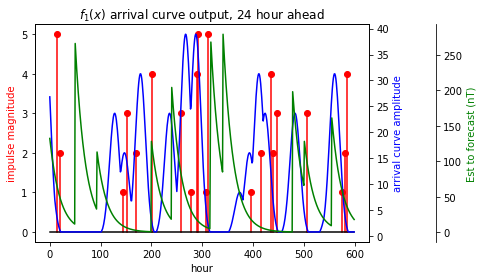

In [109]:
eval_idx = slice(0, 1000)
plot_idx = slice(200, 800)
arr_curve = sub_model_1(data_in_train[eval_idx, 0].reshape(-1, 1))

imp = data_in_train[plot_idx, 0].copy()
imp[imp == 0] = np.nan

plt.figure(figsize=[6,4])
ax1 = plt.axes()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.2))

l1 = ax1.stem(imp, linefmt='r-', markerfmt='ro', basefmt='k-', label='impulses (input 1)')
ax2.plot(arr_curve[plot_idx], 'b-', label='arrival curve')
ax3.plot(data_out_train[plot_idx], 'g-', label='Est to forecast')

ax1.set_xlabel('hour')
ax1.set_ylabel('impulse magnitude')
ax2.set_ylabel('arrival curve amplitude')
ax3.set_ylabel('Est to forecast (nT)')
plt.title('$f_1(x)$ arrival curve output, %d hour ahead' % lahead)

ax1.yaxis.label.set_color('r')
ax2.yaxis.label.set_color('b')
ax3.yaxis.label.set_color('g')

# plt.savefig('../figures/toy_model_arrivalcurve.pdf', bbox_inches='tight')

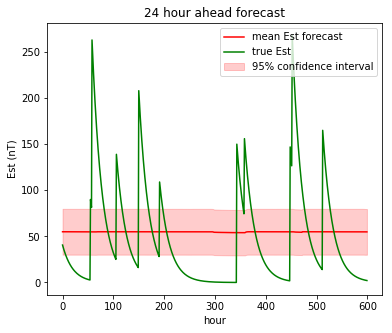

In [176]:
est_pred = model([data_in_train[eval_idx, 0].reshape(-1,1), data_in_train[eval_idx, 1].reshape(-1,1)])

fig = plt.figure(figsize=[6,5])

ax1 = plt.axes()
# ax2 = ax1.twinx()

ax1.plot(est_pred.mean()[plot_idx], 'r-', label='mean Est forecast')
ax1.fill_between(np.arange(len(data_in_train[plot_idx, 0])),
                 est_pred.loc.numpy().reshape(-1)[plot_idx]-
                         2*est_pred.scale.numpy().reshape(-1)[plot_idx], 
                 est_pred.loc.numpy().reshape(-1)[plot_idx]+
                         2*est_pred.scale.numpy().reshape(-1)[plot_idx],
                color='r', alpha=0.2, label='95% confidence interval')
ax1.plot(data_out_train[plot_idx], 'g-', label='true Est')
# ax1.plot(data_in_train[plot_idx, 1], 'k--', label='previous Est (input)')
# ax2.plot(arr_curve[plot_idx], 'b', label='arrival curve')

ax1.set_xlabel('hour')
ax1.set_ylabel('Est (nT)')
# ax2.set_ylabel('arrival curve amplitude')
plt.title('%d hour ahead forecast' % lahead)
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
# plt.savefig('../figures/toy_model_24hourforecast.pdf', bbox_inches='tight')

### Reliability

In [59]:
data_out_train_pred = model([data_in_train[:, 0].reshape(-1,1), data_in_train[:, 1].reshape(-1,1)])

data_out_train_pred_loc = data_out_train_pred.loc.numpy()
data_out_train_pred_scale = data_out_train_pred.scale.numpy()
data_out_train_pred_tmp = [stats.norm(loc=loc, scale=scale) for loc, scale in zip(data_out_train_pred_loc, data_out_train_pred_scale)]

In [60]:
# compute reliability curves
thres = [50, 100, 150, 200]
nthres = len(thres)
bin_edges = np.linspace(0, 1, 15)
bins = np.diff(bin_edges)/2 + bin_edges[0:-1]
nbins = len(bins)
first = False
exc = 'geq'

obs_exc = np.zeros((nbins, nthres))
for ii in range(nthres):
    obs_exc[:, ii] = reliability(data_out_train_pred_tmp, data_out_train, 
                                 thres[ii], 
                                 bin_edges, 
                                 exc=exc, 
                                 first=first)

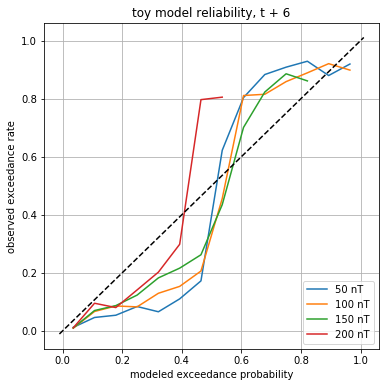

In [62]:
plt.figure(figsize=[6, 6])
for ii in range(nthres):
    plt.plot(bins, obs_exc[:,ii], label=str(thres[ii])+' nT')
abline(1, 0)
plt.xlabel('modeled exceedance probability')
plt.ylabel('observed exceedance rate')
plt.title('toy model reliability, t + %d' % lahead)
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig('../figures/toy_model_reliability_t+6.pdf', format='pdf', bbox_inches='tight')
plt.show()